# Mouse Training Notebook

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os

os.chdir("..")
xla_flags = os.environ.get("XLA_FLAGS", "")
xla_flags += " --xla_gpu_triton_gemm_any=True"
os.environ["XLA_FLAGS"] = xla_flags
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"

In [13]:
import functools
import json
from datetime import datetime

import jax
from jax.experimental import checkify
import jax.numpy as jp
import matplotlib.pyplot as plt
import mediapy as media
import mujoco
import wandb
from brax.training.agents.ppo import networks as ppo_networks
from brax.training.agents.ppo import train as ppo
from etils import epath
from flax.training import orbax_utils
from IPython.display import clear_output, display
from orbax import checkpoint as ocp
from tqdm import tqdm

from mujoco_playground import locomotion, wrapper
from mujoco_playground.config import locomotion_params

from vnl_mjx.tasks.mouse import mouse_reach

jax.config.update("jax_debug_nans", True)

# # Enable persistent compilation cache.
jax.config.update("jax_compilation_cache_dir", "/tmp/jax_cache")
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [7]:
# from track_mjx.environment import custom_wrappers
from track_mjx.environment import wrappers

In [4]:
from ml_collections import config_dict

ppo_params = config_dict.create(
    num_timesteps=100_000_000,
    num_evals=10,
    reward_scaling=1.0,
    episode_length=1000,
    normalize_observations=True,
    action_repeat=1,
    unroll_length=20,
    num_minibatches=32,
    num_updates_per_batch=4,
    discounting=0.97,
    learning_rate=1e-4,
    entropy_cost=1e-4,
    num_envs=8192,
    batch_size=256,
    max_grad_norm=1.0,
    network_factory=config_dict.create(
        policy_hidden_layer_sizes=(512, 512, 512),
        value_hidden_layer_sizes=(512, 512, 512),
        policy_obs_key="state",
        value_obs_key="state",
    ),
)

env_name = "mouse-reach"

In [5]:
from pprint import pprint

ppo_params.num_evals = 150
ppo_params.num_envs = 2048
ppo_params.episode_length = 1000
ppo_params.num_timesteps = 0  # int(5e8)
pprint(ppo_params)

action_repeat: 1
batch_size: 256
discounting: 0.97
entropy_cost: 0.0001
episode_length: 1000
learning_rate: 0.0001
max_grad_norm: 1.0
network_factory:
  policy_hidden_layer_sizes: &id001 !!python/tuple
  - 512
  - 512
  - 512
  policy_obs_key: state
  value_hidden_layer_sizes: *id001
  value_obs_key: state
normalize_observations: true
num_envs: 2048
num_evals: 150
num_minibatches: 32
num_timesteps: 0
num_updates_per_batch: 4
reward_scaling: 1.0
unroll_length: 20



In [6]:
SUFFIX = None
FINETUNE_PATH = (
    # "/root/vast/eric/vnl-mjx/checkpoints/mouse-reach-20250520-041839"
    # "/root/vast/eric/vnl-mjx/checkpoints/mouse-reach-20250520-040032"
    # "/root/vast/eric/vnl-mjx/checkpoints/mouse-reach-20250514-181555"
    "/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853"
)


# Generate unique experiment name.
now = datetime.now()
timestamp = now.strftime("%Y%m%d-%H%M%S")
exp_name = f"{env_name}-{timestamp}"
if SUFFIX is not None:
    exp_name += f"-{SUFFIX}"
print(f"Experiment name: {exp_name}")

# Possibly restore from the latest checkpoint.
if FINETUNE_PATH is not None:
    FINETUNE_PATH = epath.Path(FINETUNE_PATH)
    latest_ckpts = list(FINETUNE_PATH.glob("*"))
    latest_ckpts = [ckpt for ckpt in latest_ckpts if ckpt.is_dir()]
    latest_ckpts.sort(key=lambda x: int(x.name))
    print(latest_ckpts)
    latest_ckpt = latest_ckpts[-1]
    restore_checkpoint_path = latest_ckpt
    print(f"Restoring from: {restore_checkpoint_path}")
else:
    restore_checkpoint_path = None

Experiment name: mouse-reach-20250624-070724
[PosixGPath('/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/6717440'), PosixGPath('/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/13434880'), PosixGPath('/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/20152320'), PosixGPath('/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/26869760'), PosixGPath('/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/33587200'), PosixGPath('/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/40304640'), PosixGPath('/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/47022080'), PosixGPath('/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/53739520'), PosixGPath('/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/60456960'), PosixGPath('/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-1808

ppo_params.

In [7]:
type(ppo_params)

ml_collections.config_dict.config_dict.ConfigDict

In [8]:
x_data, y_data, y_dataerr = [], [], []
times = [datetime.now()]


def policy_params_fn(current_step, make_policy, params):
    del make_policy  # Unused.
    orbax_checkpointer = ocp.PyTreeCheckpointer()
    save_args = orbax_utils.save_args_from_target(params)
    path = f"{current_step}"
    orbax_checkpointer.save(path, params, force=True, save_args=save_args)


training_params = dict(ppo_params)
del training_params["network_factory"]

train_fn = functools.partial(
    ppo.train,
    **training_params,
    network_factory=functools.partial(
        ppo_networks.make_ppo_networks, **ppo_params.network_factory
    ),
    restore_checkpoint_path=restore_checkpoint_path,
    wrap_env_fn=wrapper.wrap_for_brax_training,
    policy_params_fn=policy_params_fn,
)

# env = flat_arena.FlatWalk()
# eval_env = flat_arena.FlatWalk()

# env = mouse_reach.MouseEnv()
# eval_env = mouse_reach.MouseEnv()
# env.add_target(random_target=True)
# eval_env.add_target(random_target=True)

# make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)

In [16]:
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

In [17]:
rng = jax.random.PRNGKey(12345)
rollout = []
rewards = []
torso_height = []
actions = []
torques = []
qfrc_constraint = []
qvels = []

for idx in range(1):
    # env.add_target(target_id=idx)
    # eval_env.add_target(target_id=idx)

    # jit_reset = jax.jit(eval_env.reset)
    # jit_step = jax.jit(eval_env.step)

    rng, reset_rng = jax.random.split(rng)
    state = jit_reset(reset_rng)

    # make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)
    # inference_fn = make_inference_fn(params, deterministic=True)
    # jit_inference_fn = jax.jit(inference_fn)
    for i in tqdm(range(300)):
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        actions.append(ctrl)
        state = jit_step(state, ctrl)
        rollout.append(state)
        rewards.append(state.reward)
        torso_height.append(state.data.qpos[2])
        torques.append(state.data.actuator_force)
        qvel = state.data.qvel[6:]
        qfrc_constraint.append(jp.linalg.norm(state.data.qfrc_constraint[6:]))
        #qvels.append(jp.max(jp.abs(qvel)))
        frc = state.data.actuator_force
        qvel = state.data.qvel[6:]

100%|██████████| 300/300 [00:10<00:00, 27.82it/s]


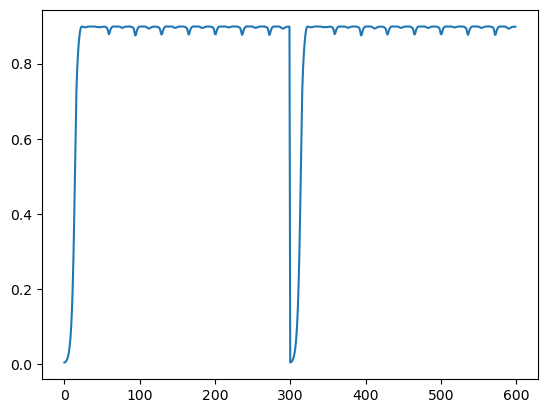

In [39]:
plt.plot(rewards)

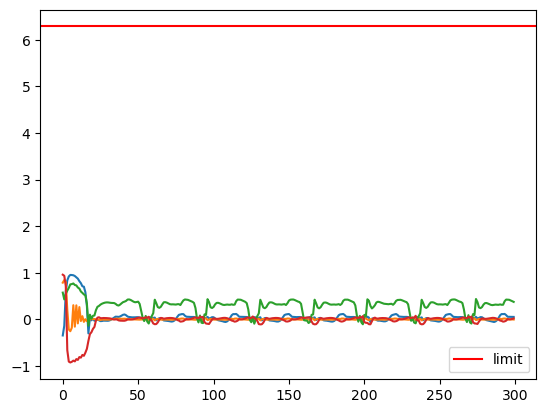

In [14]:
plt.plot(actions)
plt.axhline(2 * jp.pi, color="red", label="limit")
plt.legend()
plt.show()

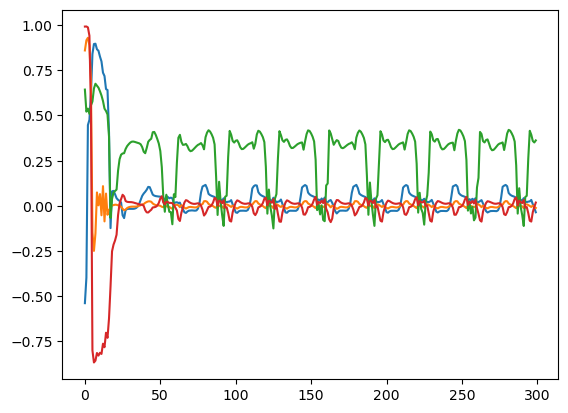

In [12]:
plt.plot(actions)

In [13]:
len(rollout)

300

In [18]:
render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]

scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

frames = eval_env.render(
    traj,
    camera="close_profile",
    scene_option=scene_option,
    height=480,
    width=640
)
media.show_video(frames, fps=30, loop=False)
# media.write_video(f"{env_name}.mp4", frames, fps=fps, qp=18)

100%|██████████| 150/150 [00:00<00:00, 539.02it/s]


# -------------------------------------------------------------------------

### Code in figuring out how to make one arm pass

In [1]:
env = mouse_reach.MouseEnv()

NameError: name 'mouse_reach' is not defined

In [24]:
env = mouse_reach.MouseEnv()
eval_env = mouse_reach.MouseEnv()
# env.add_target(pos=[0.004, 0.012, -0.006])
# eval_env.add_target(pos=[0.004, 0.012, -0.006])
env.add_target(idx=0)
eval_env.add_target(idx=0)

make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)

inference_fn = make_inference_fn(params, deterministic=True)
jit_inference_fn = jax.jit(inference_fn)

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

added target at pos:  [ 0.004  0.012 -0.006]
added target at pos:  [ 0.004  0.012 -0.006]
currently in reset with target pos [ 0.004  0.012 -0.006]
found target position at [ 0.004  0.012 -0.006]
currently in reset with target pos [ 0.004  0.012 -0.006]
model compiled with target


In [25]:
rng, reset_rng = jax.random.split(jax.random.PRNGKey(12345))
state = jit_reset(reset_rng)

print(env._spec.worldbody.sites[0].pos)
print(eval_env._spec.worldbody.sites[0].pos)

print(state.info)

currently in reset with target pos [ 0.004  0.012 -0.006]
found target position at [ 0.004  0.012 -0.006]
currently in reset with target pos [ 0.004  0.012 -0.006]
model compiled with target
[ 0.004  0.012 -0.006]
[ 0.004  0.012 -0.006]
{'target_position': Array([ 0.004,  0.012, -0.006], dtype=float32)}


In [26]:
action, _ = jit_inference_fn(state.obs, act_rng)
actions.append(action)
state = jit_step(state, action)

IN STEP, target position is [ 0.004  0.012 -0.006]


In [17]:
dir(state)
state.data
state.info

{'target_position': Array([ 0.004,  0.012, -0.006], dtype=float32)}

In [ ]:
rng = jax.random.PRNGKey(12345)
rollout = []
rewards = []
torso_height = []
actions = []
torques = []
qfrc_constraint = []
qvels = []

for _ in range(1):

    # rng, reset_rng = jax.random.split(rng)
    # state = jit_reset(reset_rng)

    for i in tqdm(range(300)):
        act_rng, rng = jax.random.split(rng)
        action, _ = jit_inference_fn(state.obs, act_rng)
        actions.append(action)
        state = jit_step(state, action)
        rollout.append(state)
        rewards.append(state.reward)
        torso_height.append(state.data.qpos[2])
        torques.append(state.data.actuator_force)
        qvel = state.data.qvel[6:]
        qfrc_constraint.append(jp.linalg.norm(state.data.qfrc_constraint[6:]))
        #qvels.append(jp.max(jp.abs(qvel)))
        frc = state.data.actuator_force
        qvel = state.data.qvel[6:]

In [29]:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

In [30]:
render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollout[::render_every]


frames = eval_env.render(
    traj,
    camera="close_profile",
    scene_option=scene_option,
    height=480,
    width=640
)
media.show_video(frames, fps=30, loop=False)
# media.write_video(f"{env_name}.mp4", frames, fps=fps, qp=18)

100%|██████████| 150/150 [00:00<00:00, 545.63it/s]


In [11]:
# dir(env._spec.bodies)
# dir(env._spec.worldbody)

In [41]:
# dir(env._spec.worldbody.sites)
for i in env._spec.worldbody.bodies:
    print(i)

In [10]:
# env._spec.worldbody.add_site()
# dir(env._spec.worldbody)

In [9]:
site = env._spec.worldbody.sites[0]
dir(site)
site.name
site.pos

array([ 0.004,  0.012, -0.006])

In [65]:
eval_env._mj_model.site('target')

<_MjModelSiteViews
  bodyid: array([0], dtype=int32)
  group: array([0], dtype=int32)
  id: 0
  matid: array([-1], dtype=int32)
  name: 'target'
  pos: array([ 0.004,  0.012, -0.006])
  quat: array([1., 0., 0., 0.])
  rgba: array([0. , 1. , 0. , 0.5], dtype=float32)
  sameframe: array([3], dtype=uint8)
  size: array([0.001, 0.001, 0.001])
  type: array([2], dtype=int32)
  user: array([], dtype=float64)
>

In [ ]:
env._spec.worldbody.sites[0].name
env._spec.worldbody
mujoco._specs.MjsBody.add_site

# -------------------------------------------------------------------------

# Actual code with mutliple arms in one pass but multiple targets on screen

In [16]:
env = mouse_reach.MouseEnv()
env.add_target(amazing_coding=True)
for site in env._spec.worldbody.sites:
    print(site.name)

sites before: 8
targets were added to sites
sites before: 8
target0
target1
target2
target3
target4
target5
target6
target7


In [26]:
# get some rng values
rng = jax.random.PRNGKey(12345)

# define environments
env = mouse_reach.MouseEnv()
eval_env = mouse_reach.MouseEnv()
# add targets
eval_env.add_target(amazing_coding=True)
env.add_target(amazing_coding=True)

# compile stuff
make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)
inference_fn = make_inference_fn(params, deterministic=True)

# further compilations with jit
jit_inference_fn = jax.jit(inference_fn)
jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)

# define rollouts
rollouts = []

for target_index in range(8):

    # begin with the RL stuff; initiate the state
    rng, reset_rng = jax.random.split(rng)
    state = jit_reset(reset_rng, amazing_index=target_index)

    for _ in tqdm(range(100)):
        action_rng, rng = jax.random.split(rng)
        action, _ = jit_inference_fn(state.obs, action_rng)
        state = jit_step(state, action)
        rollouts.append(state)

targets were added to sites;  8
targets were added to sites;  8
found target position at [ 0.004  0.012 -0.006]


100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


found target position at [ 0.0025355  0.012     -0.0024645]


100%|██████████| 100/100 [00:01<00:00, 74.51it/s]


found target position at [-0.001  0.012 -0.001]


100%|██████████| 100/100 [00:01<00:00, 81.65it/s]


found target position at [-0.0045355  0.012     -0.0024645]


100%|██████████| 100/100 [00:01<00:00, 51.39it/s]


found target position at [-0.006  0.012 -0.006]


100%|██████████| 100/100 [00:01<00:00, 65.76it/s]


found target position at [-0.0045355  0.012     -0.0095355]


100%|██████████| 100/100 [00:01<00:00, 64.80it/s]


found target position at [-0.001  0.012 -0.011]


100%|██████████| 100/100 [00:01<00:00, 72.52it/s]


found target position at [ 0.0025355  0.012     -0.0095355]


100%|██████████| 100/100 [00:01<00:00, 51.01it/s]


In [27]:
len(rollouts)

800

In [24]:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

In [29]:
render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollouts[::render_every]


frames = eval_env.render(
    traj,
    camera="close_profile",
    scene_option=scene_option,
    height=480,
    width=640
)
# media.show_video(frames, fps=30, loop=False)
media.write_video(f"{env_name}.mp4", frames, fps=30)

100%|██████████| 400/400 [00:00<00:00, 738.99it/s]


# -------------------------------------------------------------------------

# One target on screen; subsequent multiple balls

In [10]:
# env = mouse_reach.MouseEnv()
# env.add_target(amazing_coding=True)
# for site in env._spec.worldbody.sites:
#     print(site.name)

In [ ]:
# get some rng values
rng = jax.random.PRNGKey(12345)

# define rollouts
full_video_frames = []

targets = jp.array([
            [0.004, 0.012, -0.006],
            [0.0025355, 0.012, -0.0024645],
            [-0.001, 0.012, -0.001],
            [-0.0045355, 0.012, -0.0024645],
            [-0.006, 0.012, -0.006],
            [-0.0045355, 0.012, -0.0095355],
            [-0.001, 0.012, -0.011],
            [0.0025355, 0.012, -0.0095355],
        ])

for target in targets:

    rollout = []
    # define environments
    env = mouse_reach.MouseEnv()
    eval_env = mouse_reach.MouseEnv()
    # add targets
    eval_env.add_target(pos=target)
    env.add_target(pos=target)

    # compile stuff
    make_inference_fn, params, _ = train_fn(environment=env, eval_env=eval_env)
    inference_fn = make_inference_fn(params, deterministic=True)

    # further compilations with jit
    jit_inference_fn = jax.jit(inference_fn)
    jit_reset = jax.jit(eval_env.reset)
    jit_step = jax.jit(eval_env.step)

    # begin with the RL stuff; initiate the state
    rng, reset_rng = jax.random.split(rng)
    state = jit_reset(reset_rng)

    for _ in tqdm(range(100)):
        action_rng, rng = jax.random.split(rng)
        action, _ = jit_inference_fn(state.obs, action_rng)
        state = jit_step(state, action)
        rollout.append(state)
    
    frames = eval_env.render(
            rollout,
            camera="close_profile",
            scene_option=scene_option,
            height=480,
            width=640
        )
    full_video_frames += frames

got target position, [ 0.004  0.012 -0.006]
got target position, [ 0.004  0.012 -0.006]


100%|██████████| 100/100 [00:00<00:00, 571.52it/s]


got target position, [ 0.0025355  0.012     -0.0024645]
got target position, [ 0.0025355  0.012     -0.0024645]


100%|██████████| 100/100 [00:00<00:00, 567.48it/s]


got target position, [-0.001  0.012 -0.001]
got target position, [-0.001  0.012 -0.001]


100%|██████████| 100/100 [00:00<00:00, 606.52it/s]


got target position, [-0.0045355  0.012     -0.0024645]
got target position, [-0.0045355  0.012     -0.0024645]


100%|██████████| 100/100 [00:00<00:00, 572.00it/s]


got target position, [-0.006  0.012 -0.006]
got target position, [-0.006  0.012 -0.006]


100%|██████████| 100/100 [00:00<00:00, 585.16it/s]


got target position, [-0.0045355  0.012     -0.0095355]
got target position, [-0.0045355  0.012     -0.0095355]


100%|██████████| 100/100 [00:00<00:00, 586.14it/s]


got target position, [-0.001  0.012 -0.011]
got target position, [-0.001  0.012 -0.011]


100%|██████████| 100/100 [00:00<00:00, 613.69it/s]


got target position, [ 0.0025355  0.012     -0.0095355]
got target position, [ 0.0025355  0.012     -0.0095355]


100%|██████████| 100/100 [00:00<00:00, 556.57it/s]


In [12]:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False

In [27]:
r2 = rollouts[2][0]
dir(r2)
r2.info['target_position']
print(rollouts[0][-1].info['target_position'])
print(rollouts[1][-1].info['target_position'])

[ 0.004  0.012 -0.006]
[ 0.0025355  0.012     -0.0024645]


In [32]:
render_every = 2
fps = 1.0 / eval_env.dt / render_every
traj = rollouts[0] + rollouts[1] + rollouts[2]


# media.show_video(full_video_frames, fps=30, loop=False)
media.write_video(f"mouse-reach-subsequent-targets.mp4", full_video_frames, fps=30)

# -------------------------------------------------------------------------

# Checkpointing debug code

In [15]:
from track_mjx.agent import checkpointing

In [16]:
path = '/root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/1000898560'
checkpointing.load_config_from_checkpoint(path)

ValueError: No step path found with name=PPONetwork_0, NameFormat=_StandardNameFormat(step_prefix='PPONetwork', step_format_fixed_length=None) for step=0 under /root/vast/joshua/vnl-playground/checkpoints/mouse-reach-20250613-180853/1000898560.

# -------------------------------------------------------------------------

Testing target position 1/8: [ 0.004  0.012 -0.006]
Target in state.info: [ 0.004  0.012 -0.006]
Target in state.info: [ 0.004  0.012 -0.006]


Target 1: 100%|██████████| 300/300 [00:10<00:00, 29.05it/s]

100%|██████████| 150/150 [00:00<00:00, 584.37it/s]



Testing target position 2/8: [ 0.0025355  0.012     -0.0024645]
Target in state.info: [ 0.0025355  0.012     -0.0024645]
Target in state.info: [ 0.0025355  0.012     -0.0024645]


Target 2: 100%|██████████| 300/300 [00:11<00:00, 26.50it/s]

100%|██████████| 150/150 [00:00<00:00, 571.41it/s]



Testing target position 3/8: [-0.001  0.012 -0.001]
Target in state.info: [-0.001  0.012 -0.001]
Target in state.info: [-0.001  0.012 -0.001]


Target 3: 100%|██████████| 300/300 [00:12<00:00, 24.11it/s]

100%|██████████| 150/150 [00:00<00:00, 570.84it/s]



Testing target position 4/8: [-0.0045355  0.012     -0.0024645]
Target in state.info: [-0.0045355  0.012     -0.0024645]
Target in state.info: [-0.0045355  0.012     -0.0024645]


Target 4: 100%|██████████| 300/300 [00:12<00:00, 23.55it/s]

100%|██████████| 150/150 [00:00<00:00, 513.46it/s]


Testing target position 5/8: [-0.006  0.012 -0.006]
Target in state.info: [-0.006  0.012 -0.006]
Target in state.info: [-0.006  0.012 -0.006]


100%|██████████| 150/150 [00:00<00:00, 554.37it/s]



Testing target position 6/8: [-0.0045355  0.012     -0.0095355]
Target in state.info: [-0.0045355  0.012     -0.0095355]
Target in state.info: [-0.0045355  0.012     -0.0095355]


Target 6: 100%|██████████| 300/300 [00:12<00:00, 24.16it/s]

100%|██████████| 150/150 [00:00<00:00, 534.81it/s]



Testing target position 7/8: [-0.001  0.012 -0.011]
Target in state.info: [-0.001  0.012 -0.011]
Target in state.info: [-0.001  0.012 -0.011]


Target 7: 100%|██████████| 300/300 [00:10<00:00, 28.67it/s]

100%|██████████| 150/150 [00:00<00:00, 548.88it/s]



Testing target position 8/8: [ 0.0025355  0.012     -0.0095355]
Target in state.info: [ 0.0025355  0.012     -0.0095355]
Target in state.info: [ 0.0025355  0.012     -0.0095355]


Target 8: 100%|██████████| 300/300 [00:10<00:00, 28.58it/s]

100%|██████████| 150/150 [00:00<00:00, 542.78it/s]



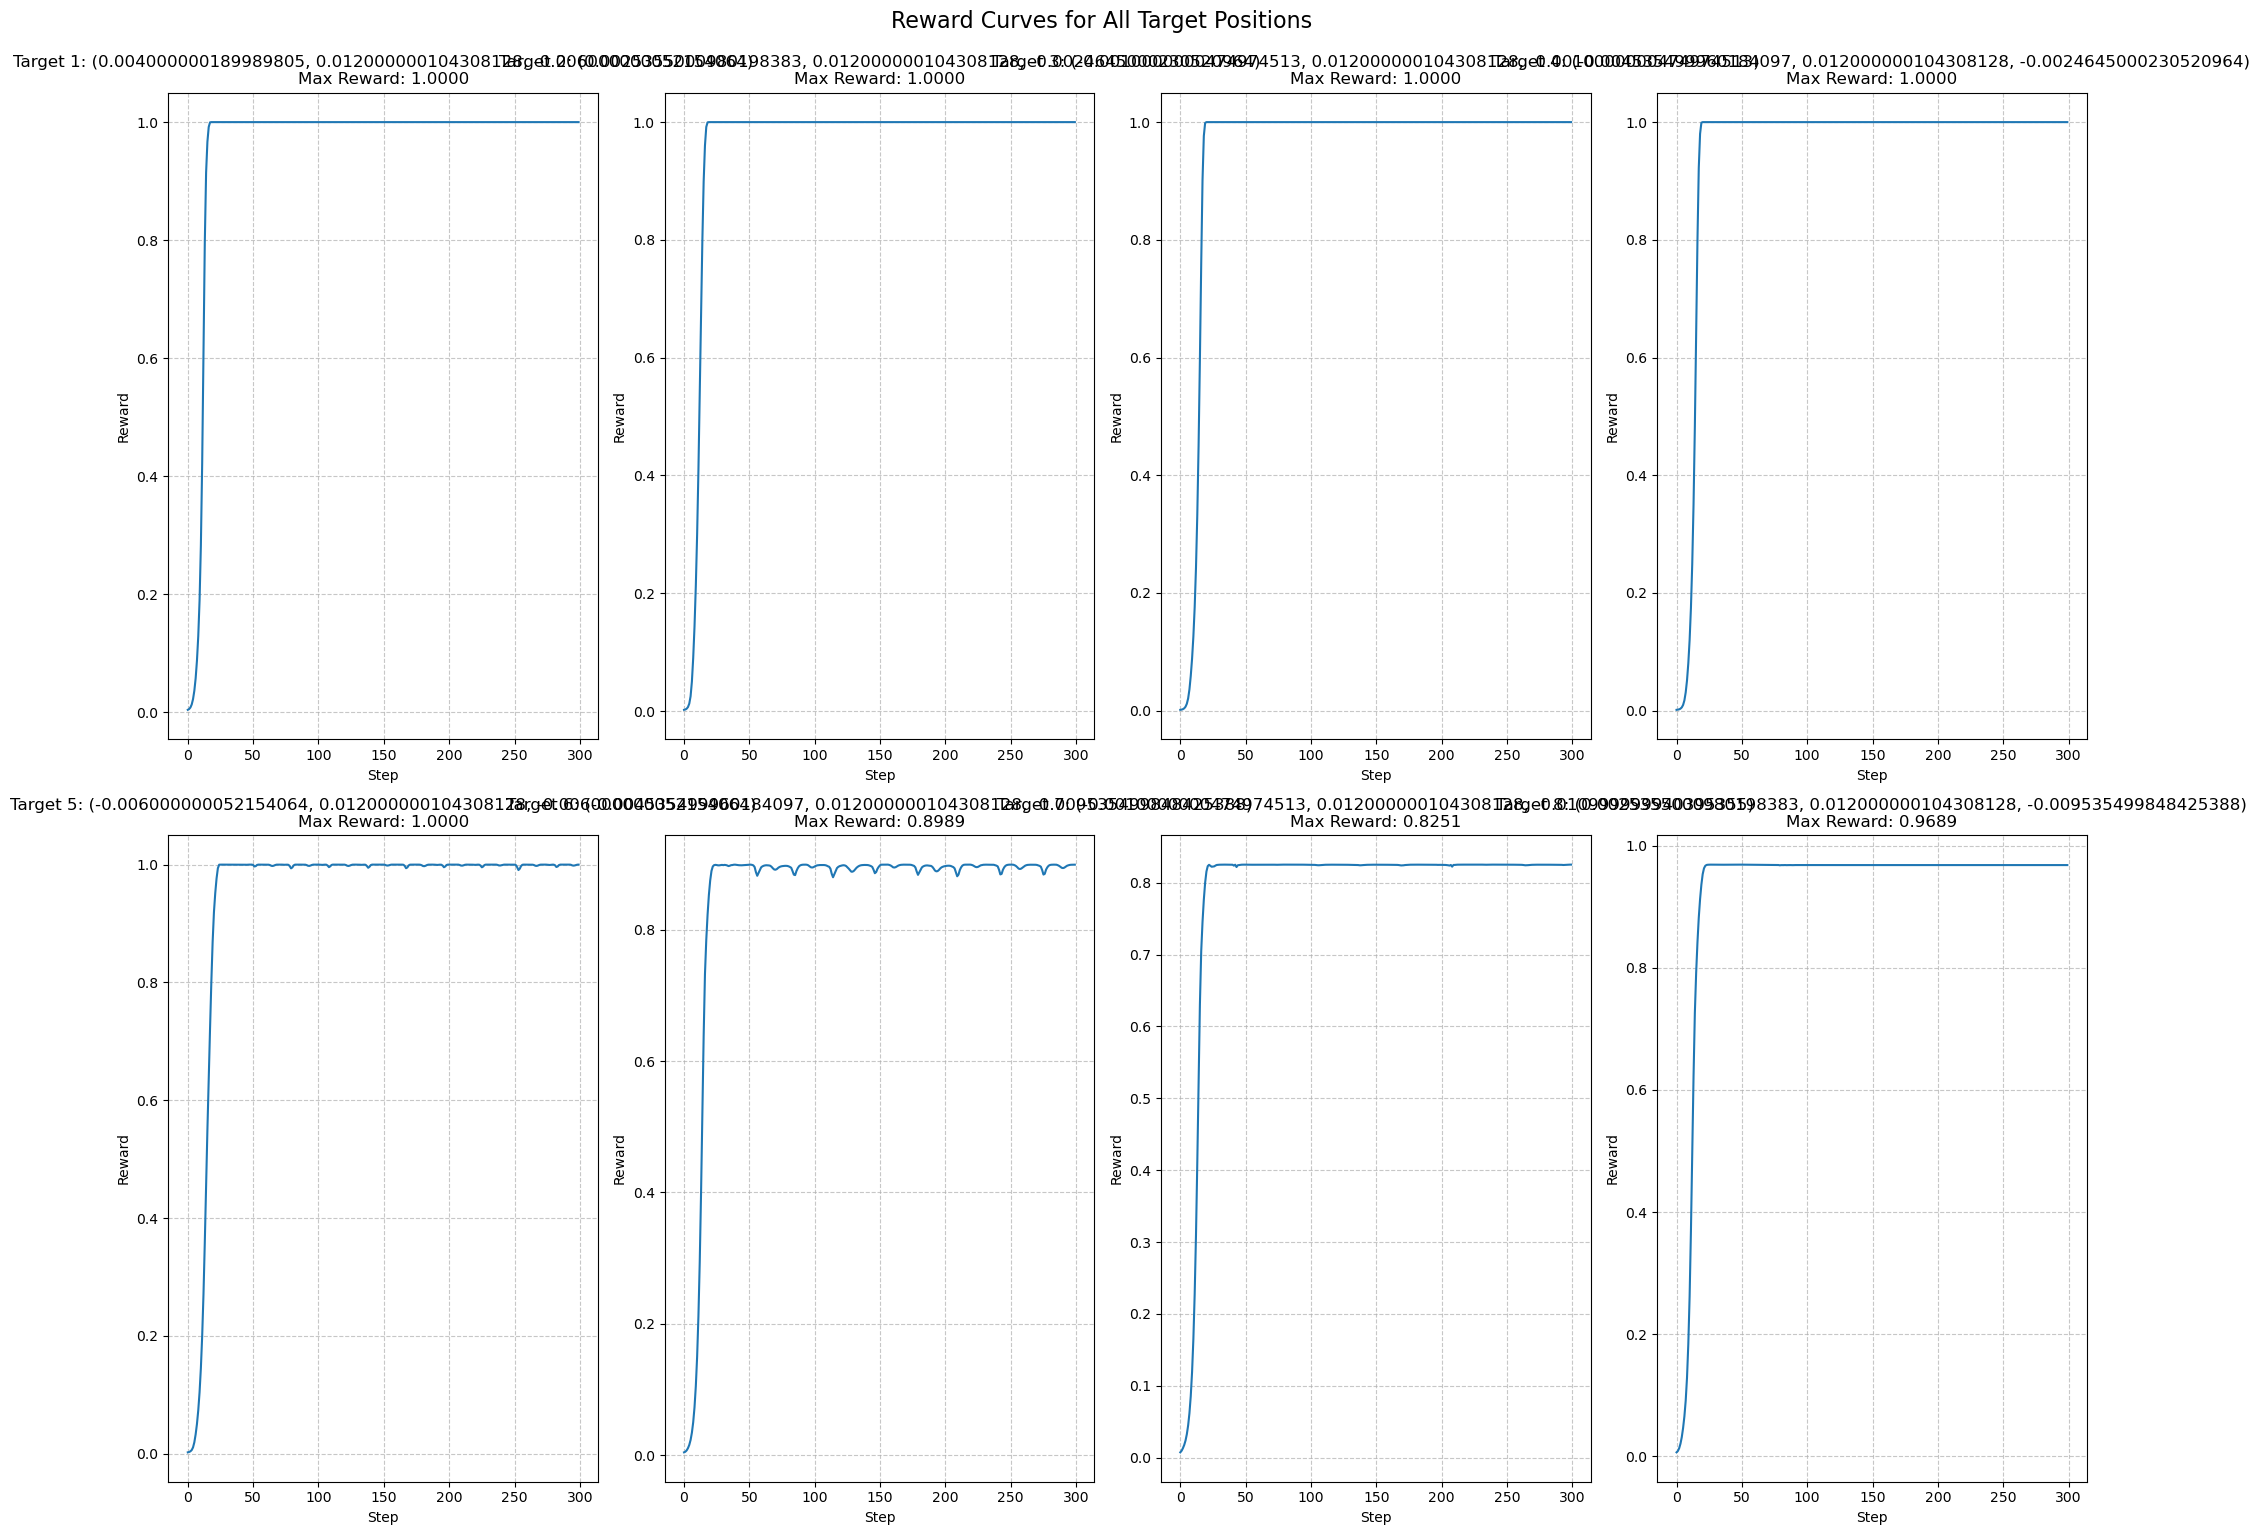

Video for target position 1/8: [0.004000000189989805, 0.012000000104308128, -0.006000000052154064]


Video for target position 2/8: [0.0025355000980198383, 0.012000000104308128, -0.0024645000230520964]


Video for target position 3/8: [-0.0010000000474974513, 0.012000000104308128, -0.0010000000474974513]


Video for target position 4/8: [-0.004535499960184097, 0.012000000104308128, -0.0024645000230520964]


Video for target position 5/8: [-0.006000000052154064, 0.012000000104308128, -0.006000000052154064]


Video for target position 6/8: [-0.004535499960184097, 0.012000000104308128, -0.009535499848425388]


Video for target position 7/8: [-0.0010000000474974513, 0.012000000104308128, -0.010999999940395355]


Video for target position 8/8: [0.0025355000980198383, 0.012000000104308128, -0.009535499848425388]


In [18]:
# Test all target positions with synchronized visual and reward targets
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# Get all target positions
target_positions = mouse_reach.MouseEnv.get_target_positions()
num_targets = len(target_positions)

# Storage for videos and rewards
all_videos = []
all_rewards = []

# Set up figure for reward plots
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(2, 4, figure=fig)

# Test each target position
for i, target_pos in enumerate(target_positions):
    print(f"Testing target position {i+1}/{num_targets}: {target_pos}")
    
    # Create environment with specific target
    test_env = mouse_reach.MouseEnv()
    
    # Convert JAX array to Python list before passing to add_target
    python_pos = target_pos.tolist()
    
    # IMPORTANT: Initialize environment with add_target first
    # This creates both the visual marker and compiles the model
    test_env.add_target(pos=python_pos)
    
    # Set up a special reset function that will maintain our specific target
    def custom_reset(rng):
        # First do normal reset
        state = test_env.reset(rng)
        
        # Override the target position with our chosen target
        # This ensures the reward calculations use our target
        state = state.replace(info={"target_position": target_pos})
        return state
    
    # Set up JIT functions
    jit_reset = jax.jit(custom_reset)
    jit_step = jax.jit(test_env.step)
    
    # Prepare for rollout
    rng = jax.random.PRNGKey(12345 + i)
    rollout = []
    rewards = []
    
    # Run episode
    rng, reset_rng = jax.random.split(rng)
    state = jit_reset(reset_rng)
    
    # Verify target is what we expect
    print(f"Target in state.info: {state.info['target_position']}")
    
    for _ in tqdm(range(300), desc=f"Target {i+1}"):
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        state = jit_step(state, ctrl)
        rollout.append(state)
        rewards.append(state.reward)
    
    # Store rewards for plotting
    all_rewards.append(rewards)
    
    # Render video
    render_every = 2
    fps = 1.0 / test_env.dt / render_every
    traj = rollout[::render_every]
    
    scene_option = mujoco.MjvOption()
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True  # Set transparent to see target better
    
    frames = test_env.render(
        traj,
        camera="close_profile",
        scene_option=scene_option,
        height=480,
        width=640,
    )
    all_videos.append(frames)
    
    # Plot reward curve
    ax = fig.add_subplot(gs[i // 4, i % 4])
    ax.plot(rewards)
    max_reward = max(rewards)
    ax.set_title(f"Target {i+1}: {tuple(python_pos)}\nMax Reward: {max_reward:.4f}")
    ax.set_xlabel("Step")
    ax.set_ylabel("Reward")
    ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and show reward plots
plt.tight_layout()
plt.suptitle("Reward Curves for All Target Positions", fontsize=16, y=1.02)
plt.show()

# Display videos for each target
for i, frames in enumerate(all_videos):
    print(f"Video for target position {i+1}/{num_targets}: {target_positions[i].tolist()}")
    media.show_video(frames, fps=fps * 2, loop=False)
    
    # Uncomment to save videos
    # media.write_video(f"mouse_target_{i+1}.mp4", frames, fps=fps, qp=18)

In [18]:
# Improved target visualization test
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

# Get all target positions
target_positions = mouse_reach.MouseEnv.get_target_positions()
num_targets = len(target_positions)

# Storage for videos and rewards
all_videos = []
all_rewards = []

# Set up figure for reward plots
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(2, 4, figure=fig)

# Test each target position
for i, target_pos in enumerate(target_positions):
    print(f"Testing target position {i+1}/{num_targets}: {target_pos}")
    
    # Create environment with specific target
    test_env = mouse_reach.MouseEnv()
    
    # Convert JAX array to Python list before passing to add_target
    python_pos = target_pos.tolist()
    
    # Add target with exact position
    #test_env.add_target(pos=python_pos)
    
    # Verify target position in model
    print(f"Target position set to: {python_pos}")
    
    # Set up JIT functions
    jit_reset = jax.jit(test_env.reset)
    jit_step = jax.jit(test_env.step)
    
    # Prepare for rollout
    rng = jax.random.PRNGKey(12345 + i)  # Different seed for each target
    rollout = []
    rewards = []
    
    # Run episode
    rng, reset_rng = jax.random.split(rng)
    state = jit_reset(reset_rng)
    
    # Verify target in observation
    if hasattr(state.obs, 'get') and state.obs.get('target_pos') is not None:
        target_in_obs = state.obs.get('target_pos')
        print(f"Target in observation: {target_in_obs}")
        # Verify it matches the intended position
        obs_matches = np.allclose(np.array(target_in_obs), np.array(python_pos), rtol=1e-5)
        print(f"Observation matches target position: {obs_matches}")
    
    # Run the episode
    for step in tqdm(range(300), desc=f"Target {i+1}"):
        act_rng, rng = jax.random.split(rng)
        ctrl, _ = jit_inference_fn(state.obs, act_rng)
        state = jit_step(state, ctrl)
        rollout.append(state)
        rewards.append(state.reward)
    
    # Store rewards for plotting
    all_rewards.append(rewards)
    
    # Render video with enhanced target visibility
    render_every = 2
    fps = 1.0 / test_env.dt / render_every
    traj = rollout[::render_every]
    
    # Setup scene options for clear target visualization
    scene_option = mujoco.MjvOption()
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = False
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
    
    # Make target site more prominent in visualization
    # Render from two camera angles to better see the target
    frames_profile = test_env.render(
        traj,
        camera="close_profile",
        scene_option=scene_option,
        height=480,
        width=640,
    )
    
    # Add an overhead view for better target visibility
    frames_overhead = test_env.render(
        traj,
        camera="overhead",  # Assuming this camera exists, otherwise use another appropriate camera
        scene_option=scene_option,
        height=480,
        width=640,
    )
    
    # Store videos for later display
    all_videos.append((frames_profile, frames_overhead))
    
    # Plot reward curve
    ax = fig.add_subplot(gs[i // 4, i % 4])
    ax.plot(rewards)
    max_reward = max(rewards)
    ax.set_title(f"Target {i+1}: {tuple(python_pos)}\nMax Reward: {max_reward:.4f}")
    ax.set_xlabel("Step")
    ax.set_ylabel("Reward")
    ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and show reward plots
plt.tight_layout()
plt.suptitle("Reward Curves for All Target Positions", fontsize=16, y=1.02)
plt.show()

# Display videos for each target
for i, (frames_profile, frames_overhead) in enumerate(all_videos):
    print(f"\nTarget position {i+1}/{num_targets}: {target_positions[i].tolist()}")
    
    print("Profile view:")
    media.show_video(frames_profile, fps=fps * 2, loop=False)
    
    print("Overhead view (better for target visibility):")
    media.show_video(frames_overhead, fps=fps * 2, loop=False)
    
    # Optional: uncomment to save videos
    # media.write_video(f"mouse_target_{i+1}_profile.mp4", frames_profile, fps=fps, qp=18)
    # media.write_video(f"mouse_target_{i+1}_overhead.mp4", frames_overhead, fps=fps, qp=18)

Testing target position 1/1: [-0.0045355  0.012     -0.0095355]
Target position set to: [-0.004535499960184097, 0.012000000104308128, -0.009535499848425388]


AttributeError: 'MouseEnv' object has no attribute '_mjx_model'

<Figure size 2000x1500 with 0 Axes>